### General advice (delete this cell before submitting for review)

> * Remove the "**Sign up to the DEA Sandbox** to run this notebook interactively from a browser" header text if the notebook is not DEA Sandbox-compatible or if it is not synced to the DEA Sandbox (e.g. `Scientific_workflows` notebooks)
> * Update the **Compatibility** line depending on whether the notebook is compatible with the `NCI` and `DEA Sandbox` environments (e.g. "Notebook currently compatible with the `DEA Sandbox` environment only" or "Notebook currently compatible with the `NCI` environment only")
> * When adding **Products used**, embed the hyperlink to that specific product on the DEA Explorer using the `[product_name](product url)` syntax.
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * Use Australian English in markdown cells and code comments.
> * Check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DEA docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in heirachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
> * For additional guidance, refer to the style conventions and layouts in approved `develop` branch notebooks. 
Examples include
    * [Frequently_used_code/Using_load_ard.ipynb](./Frequently_used_code/Using_load_ard.ipynb)
    * [Real_world_examples/Coastal_erosion.ipynb](./Real_world_examples/Coastal_erosion.ipynb)
    * [Scripts/dea_datahandling.py](./Scripts/dea_datahandling.py)
> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


# GA Burnt Area method <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with specific `DEA Dev Sandbox` environment: HNRS test
* **Products used:** 
[ga_ls8c_nbart_gm_4fyear_3](http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/)
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** run in the HNRS test DEA dev sandbox environment
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
As part of the ARDC Bushfire Data Challenge, this notebook was developed based on the code used for our S2 NRT burnt area product. This notebook calculates burnt area using varoius characteristics that indicate burnt area: delta NBR, delta BSI and delta NDVI, and so we call it the Burnt Area Characteristics (BAC) Method.

## Description
This notebook runs on Landsat 8, 7, and 5 data, mapping burnt areas using a range of change metrics. These are delta normalised burn ratio, delta bare soil index, and delta normalised vegetation difference index.

We use these with a 4 year geomedian from before the fire season and then data from the fire season.

1. First we load in both the pre fire and ante/post fire data
2. We calculate the pre and post fire event indices (NBR, BSI, NDVI)
3. Then we calculate the deltas
4. Reduce down to a single image to use
5. Then we take thresholds and find agreement between the indices for burnt areas
6. And finally we save the outputs as both vectors (json) and rasters (geotiffs).

***

## Getting started

To run this notebook you need to be in a HNRS sandbox environment, so that you can access the 4 year geomedians which are not stored in a public folder as they are an intermediate product purely for running analysis.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [20]:
%matplotlib inline

import os
import datacube
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray
import rasterio.features
import rioxarray
import sys
sys.path.insert(1, '../../Tools/')

from dea_tools.plotting import rgb
from dea_tools.datahandling import load_ard
from skimage import morphology 
from scipy import ndimage
from shapely.geometry import shape
from shapely.geometry import Polygon
from datacube.utils.geometry import Geometry, CRS
from datacube.utils.cog import write_cog
from odc.dscache.tools.tiling import parse_gridspec_with_name
from typing import List, Tuple

Setting up the notebook to access the correct path for the data (using
 the HNRS test environment in DEA dev sandbox) by setting up the configs

In [9]:
# the normal config
odc_config = {'db_hostname': os.getenv("DB_HOSTNAME"),
              'db_password': os.getenv("ODC_DB_PASSWORD"),
              'db_username': os.getenv("ODC_DB_USERNAME"),
              'db_port': 5432,
              'db_database': os.getenv("ODC_DB_DATABASE")}

In [11]:
#the special config for our multi year geomedian
hnrs_config = {'db_hostname': os.getenv("DB_HOSTNAME"),
               'db_password': os.getenv("HNRS_DC_DB_PASSWORD"),
               'db_username': os.getenv("HNRS_DC_DB_USERNAME"),
               'db_port': 5432,
               'db_database': os.getenv("HNRS_DC_DB_DATABASE")}


In [10]:
# need to set the AWS login so that we can access the data we need
os.environ["AWS_NO_SIGN_REQUEST"] = "Yes"

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name. This connects us to the 2 s3 buckets we need to access, because our multi year geomedians are saved in a different location.

In [12]:
# this is how we will access the normal data and get our results from the time of the
# fire and post fire 
dc = datacube.Datacube(app="post", config=odc_config)
# this is how we get the multi year geomedian to use as our pre-fire data
hnrs_dc = datacube.Datacube(app="geomed_loading", config=hnrs_config)

### Analysis parameters

This notebook is set up to run a whole tile area, so from the AU30 grid, select the tile name that you are after e.g. "x32y15"

* `xy`: A string containing the name of the tile you would like to investigate (e.g. `"x32y15"`). 



In [13]:
xy = 'x32y15'

## 1. Loading the data

Now that we have selected our area of interest (tile) we can load it in. To do this we need to get the polygon that we can then feed into `dc.load` and `load_ard`.

> **Note:** Use this markdown format (sparingly) to draw particular attention to an important point or caveat

In [14]:
def _get_gpgon(
    region_id: str,
) -> Tuple[datacube.utils.geometry.Geometry, datacube.utils.geometry._base.GeoBox]:
    """
    Get a geometry that covers the specified region for use with datacube.load().

    Parameters
    ----------
    region_id : str
        The ID of the region to get a geometry for. E.g. x30y29

    Returns
    -------
    Tuple[datacube.utils.geometry.Geometry, datacube.utils.geometry._base.GeoBox]
        The geometry object representing the region specified by `region_id` and the corresponding geobox.
    """

    _, gridspec = parse_gridspec_with_name("au-30")

    # gridspec : au-30
    pattern = r"x(\d+)y(\d+)"

    match = re.match(pattern, region_id)

    if match:
        x = int(match.group(1))
        y = int(match.group(2))
    else:
        logger.error(
            "No match found in region id %s.",
            region_id,
        )
        # cannot extract geobox, so we stop here.
        # if we throw exception, it will trigger the Airflow/Argo retry.
        sys.exit(0)

    geobox = gridspec.tile_geobox((x, y))

    # Return the resulting Geometry object
    return datacube.utils.geometry.Geometry(geobox.extent.geom, crs="epsg:3577"), geobox

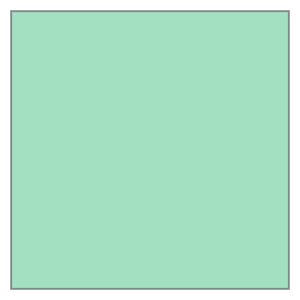

In [17]:
#running the polygon function, and getting a usable polygon out
box = _get_gpgon(xy)
pgon = box[0]
pgon

Load in the 4 (financial or calendar) year geomedian, this is our *Pre Fire Data*.
Use `ga_ls8c_nbart_gm_4cyear_3` for calendar year or `ga_ls8c_nbart_gm_4fyear_3` for financial year. Instead of inputting a geopolygon you can also input x and y coordinates. The times here are for a geomedian ending in June or December 2019. This is to run 2020 data, e.g. July 2019 to June 2020, or January 2020 to December 2020.

In [18]:
# PRE FIRE DATA
# load in the 4 (financial or calendar) year geomedian
ds = hnrs_dc.load(product="ga_ls8c_nbart_gm_4cyear_3",
             #x=(136.5, 137.5),
             #y=(-35.6, -36.1),
             geopolygon = pgon,
             time=("2017-01-01", "2017-12-31"), #calendar year
             #time=("2016-07-01", "2019-06-30"), #financial year
             output_crs="EPSG:3577")

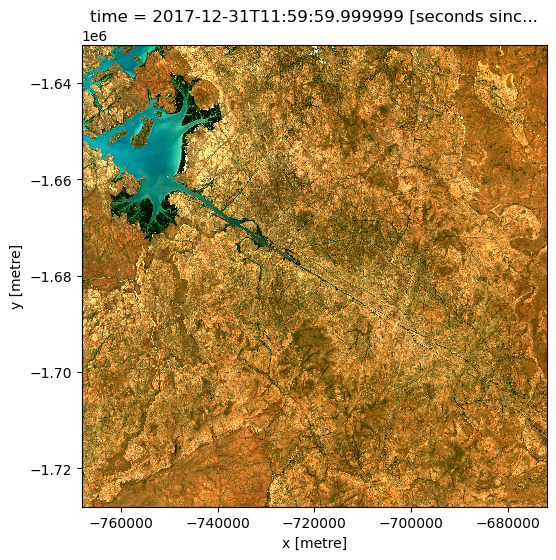

In [19]:
#check the loaded area by plotting it
rgb(ds, bands=["red", "green", "blue"], index=0)

Load in the year of interest (in this case 2020), this is our *Post Fire Data*.
Use all of the landsat sensors `ga_ls5t_ard_3`, `ga_ls7e_ard_3`, `ga_ls8c_ard_3`. Instead of inputting a geopolygon you can also input x and y coordinates. This is to run 2020 data, e.g. July 2019 to June 2020, or January 2020 to December 2020.

We use a `min_gooddata` of 0.7 to make sure each of our frames has at least 70% good data in them to ensure quality of the final product.


In [ ]:
# POST FIRE DATA
#load the post fire data, or the year of interest
post_ds = load_ard(dc= dc, 
             products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
             #x=(136.5, 137.5),
             #y=(-35.6, -36.1),
             geopolygon = pgon,
             time=("2020-01-01", "2020-12-31"), #calendar year
             #time=("2019-07-01", "2020-06-30"), # financial year
             group_by='solar_day', 
             min_gooddata=0.7,
             output_crs="EPSG:3577")

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 33 out of 85 time steps with at least 60.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 33 time steps


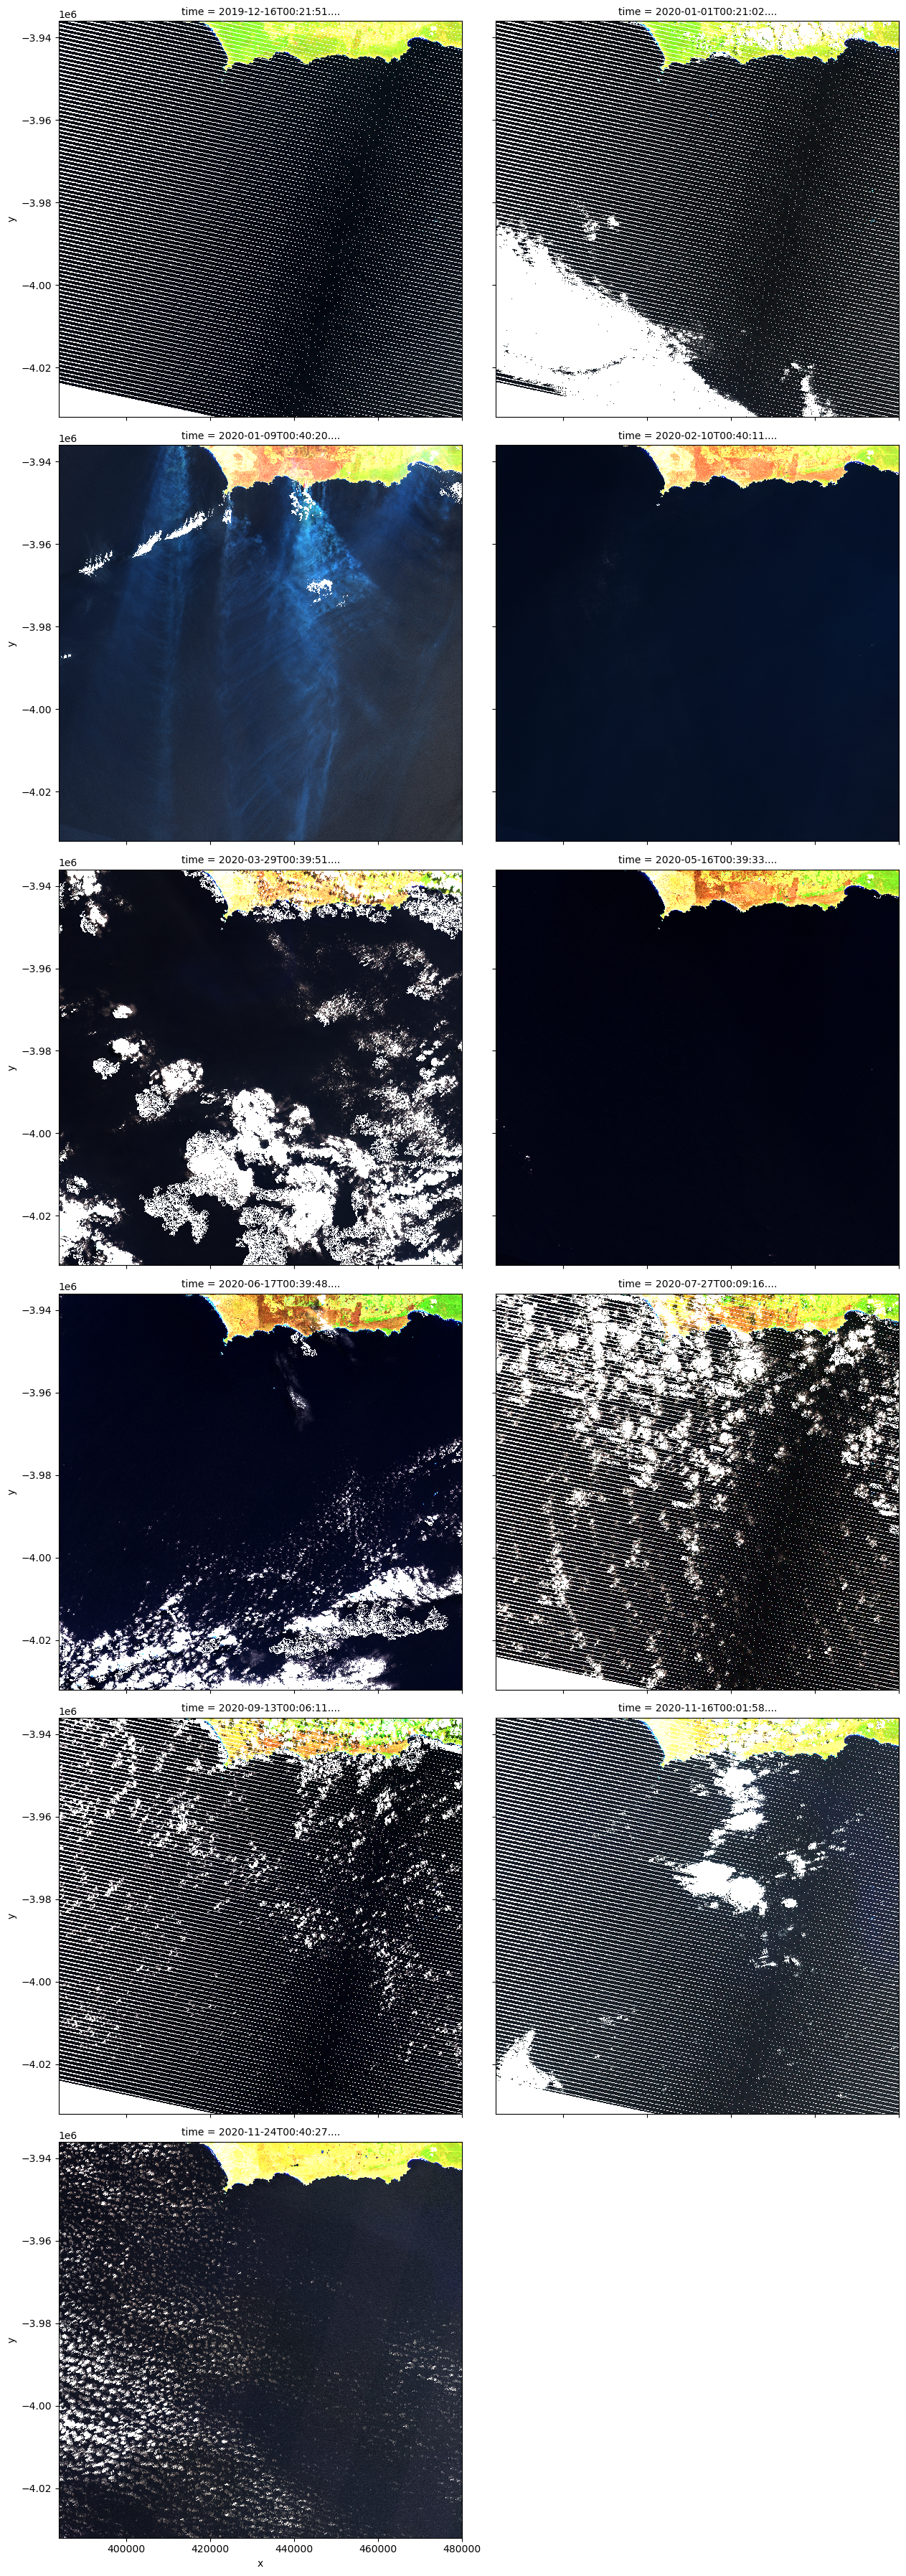

In [31]:
# plot the loaded Post Fire Data, if you look at these images you'll be able to see 
# when the fire most likely occurred.
# keep in mind that plotting uses up memory, so it is best ot avoid plots if you are
# running a whole tile for processing.
rgb(post_ds, bands=["nbart_swir_1","nbart_nir","nbart_green"], col="time", col_wrap=2)

Load in the `wofs_summary` for the area and year of interest, you can load `ga_ls_wo_fq_cyear_3` or `ga_ls_wo_fq_fyear_3`, depending on whether you are looking at the calendar or financial year dataset.

In [73]:
#load wo to mask out the ocean later
wofs_summary = dc.load(product="ga_ls_wo_fq_cyear_3",
             #x=(136.5, 137.5),
             #y=(-35.6, -36.1),
             #x=(136.5, 137.),
             #y=(-35.6, -36.1),
             geopolygon = pgon,
             #time=("2019-12-31")) #financial year
             time=("2020")) #calendar year
wofs_summary

<xarray.Dataset>
Dimensions:      (time: 1, y: 3200, x: 3200)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -1.632e+06 -1.632e+06 ... -1.728e+06 -1.728e+06
  * x            (x) float64 -8.64e+05 -8.64e+05 ... -7.68e+05 -7.68e+05
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 28 27 28 29 28 29 28 29 ... 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 28 28 28 29 28 29 29 ... 31 32 32 32 32 32
    frequency    (time, y, x) float32 1.0 0.9643 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## 2. Calculating the Pre and Post data


### Pre Fire Data

In [74]:
# normalised burn ratio
pre_nbr = (ds.nir - ds.swir2) / (
    ds.nir + ds.swir2
)

In [75]:
# bare soil index
pre_bsi = (
    (ds.swir2 + ds.red)
    - (ds.nir + ds.blue)
) / (
    (ds.swir2 + ds.red)
    + (ds.nir + ds.blue)
)

In [76]:
# normalised difference vegetation index
pre_ndvi = (ds.nir - ds.red) / (
    ds.nir + ds.red
)

### Post Fire Data

In [77]:
# normalised burn ratio
post_nbr = (post_ds.nbart_nir - post_ds.nbart_swir_2) / (
    post_ds.nbart_nir + post_ds.nbart_swir_2
)

In [78]:
# bare soil index
post_bsi = (
    (post_ds.nbart_swir_2 + post_ds.nbart_red)
    - (post_ds.nbart_nir + post_ds.nbart_blue)
) / (
    (post_ds.nbart_swir_2 + post_ds.nbart_red)
    + (post_ds.nbart_nir + post_ds.nbart_blue)
)

In [79]:
# normalised difference vegetation index
post_ndvi = (post_ds.nbart_nir - post_ds.nbart_red) / (
    post_ds.nbart_nir + post_ds.nbart_red
)

## 3. Calculate the Deltas

In [80]:
# delta normalised burn ratio
delta_nbr = pre_nbr.squeeze("time")-post_nbr

In [81]:
# delta bare soil index
delta_bsi = pre_bsi.squeeze("time")-post_bsi

In [82]:
# delta normalised difference vegetation index
delta_ndvi = pre_ndvi.squeeze("time")-post_ndvi

### Plotting the delta images

In [ ]:
# plot the delta normalised burn ratio
delta_nbr.plot(col="time", col_wrap=2, vmin=-1, vmax=1, cmap="PiYG")

In [ ]:
# plot the delta bare soil index
delta_bsi.plot(col="time", col_wrap=2,vmin=-1, vmax=1, cmap="PiYG")

In [ ]:
# plot the delta normalised difference vegetation index
delta_ndvi.plot(col="time", col_wrap=2,vmin=-1, vmax=1, cmap="PiYG")

### Masking out the Ocean and other Water

Note the plotting code is commented out here, simply uncomment it if you have memory available.

In [83]:
#masking the water and ocean
wofs_summary_frequency = wofs_summary.frequency
#wofs_summary_frequency.plot()

In [84]:
# Create a water mask by identifying areas with water frequency greater than or equal to 0.2
water_mask = xr.where(wofs_summary_frequency < 0.2, 1., wofs_summary_frequency*0.)
#water_mask.plot()

In [85]:
# mask the delta normalised burn ratio
wo_delta_nbr = water_mask.squeeze("time") * delta_nbr
#wo_delta_nbr.plot(col="time", col_wrap=2, vmin=-1, vmax=1, cmap="PiYG")

In [86]:
# mask the delta bare soil index
wo_delta_bsi = water_mask.squeeze("time") * delta_bsi
#wo_delta_bsi.plot(col="time", col_wrap=2, vmin=-1, vmax=1, cmap="PiYG")

In [87]:
# mask the delta normalised difference vegetation index
wo_delta_ndvi = water_mask.squeeze("time") * delta_ndvi
#wo_delta_ndvi.plot(col="time", col_wrap=2, vmin=-1, vmax=1, cmap="PiYG")

## 4. Reducing time period down to a single dataset / time

In [88]:
# finding the most burnt characteristic for each pixel in each dataset for the time period
delta_nbr_reduced = wo_delta_nbr.max("time") 
delta_ndvi_reduced = wo_delta_ndvi.max("time") 
delta_bsi_reduced = wo_delta_bsi.min("time") 

# # standardising so all on same negative to positive scale so that very burnt =1
delta_bsi_reduced = delta_bsi_reduced *-1 # 

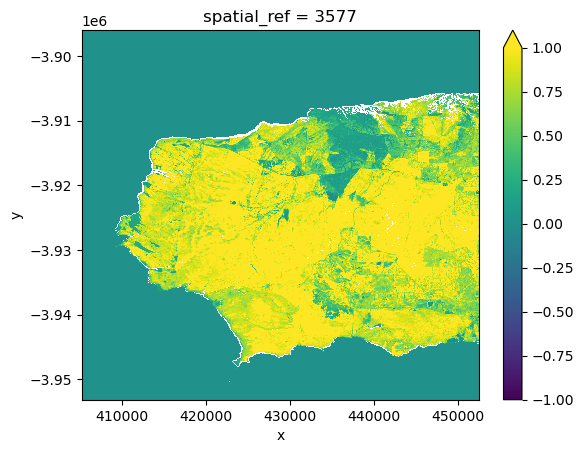

In [29]:
# plot the reduced delta normalised burn ratio
delta_nbr_reduced.plot(vmax=1, vmin=-1)

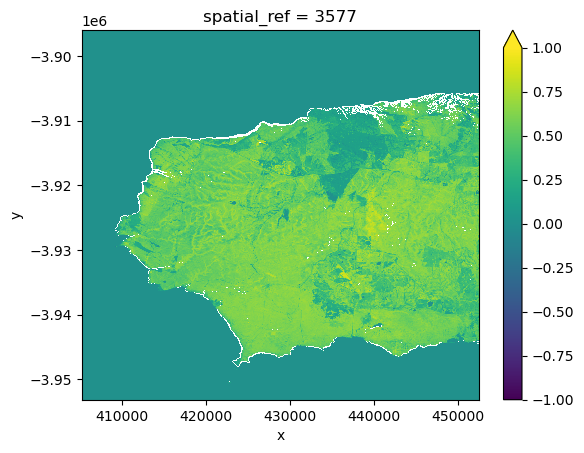

In [30]:
# plot the reduced delta normalised difference vegetation index
delta_ndvi_reduced.plot(vmax=1, vmin=-1)

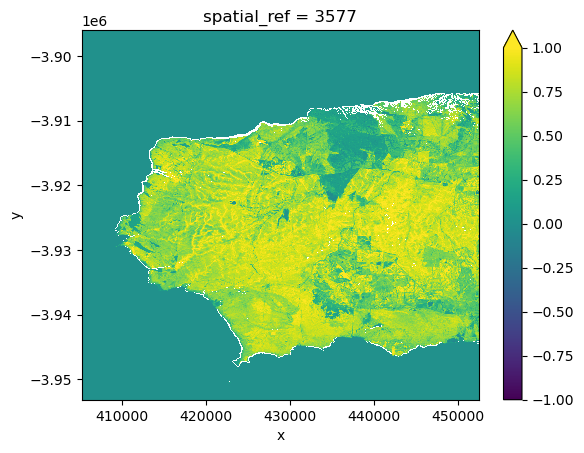

In [31]:
# plot the reduced delta bare soil index
delta_bsi_reduced.plot(vmax=1, vmin=-1)

## 5. Threshold

Each characteristic has a different threshold value, all of which were found from the literature. The threshold for the normalised burn ratio comes from a [USGS recommendation](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio) (table 1) stating that 0.44 and above is where moderate-high severity burns would be detected. For the bare soil index the used threshold value of 0.55 comes from figure 6a of [Nguyen et al. 2021](https://www.mdpi.com/2073-445X/10/3/231). And for the normalised difference vegetation index the value of 0.65 comes from table 1 of [Szajewska 2018](https://www.matec-conferences.org/articles/matecconf/abs/2018/106/matecconf_fese2018_00017/matecconf_fese2018_00017.html).

In [89]:
# take the threshold of the various characteristics
threshold_dbsi = (delta_bsi_reduced >= 0.55 )*1 #Nguyen 2021
threshold_dnbr = (delta_nbr_reduced >= 0.44 )*1 #USGS
threshold_dndvi = (delta_ndvi_reduced >= 0.65 )*1 #Szajewska 2018

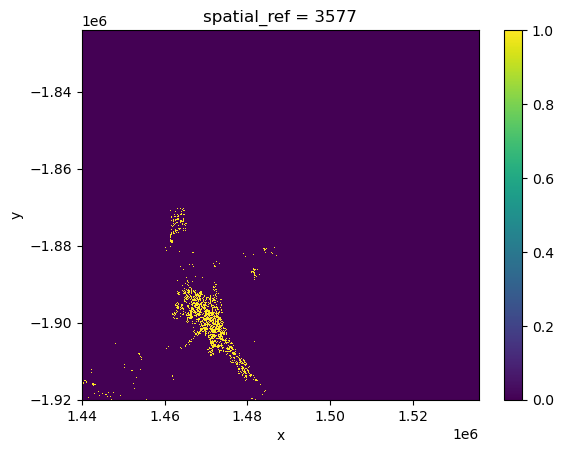

In [60]:
#plot the thresholded reduced delta normalised burn ratio
threshold_dnbr.plot()

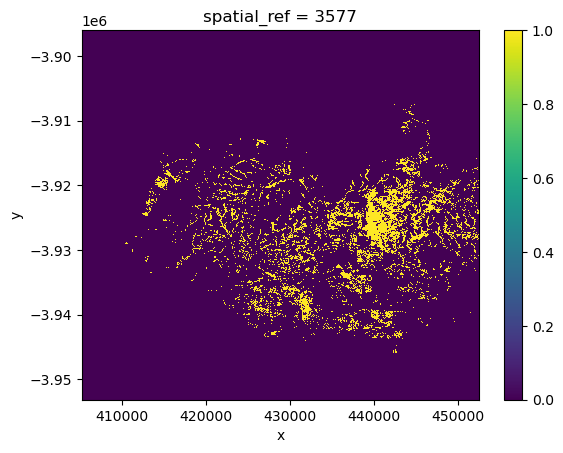

In [34]:
#plot the thresholded reduced delta normalised difference vegetation index
threshold_dndvi.plot()

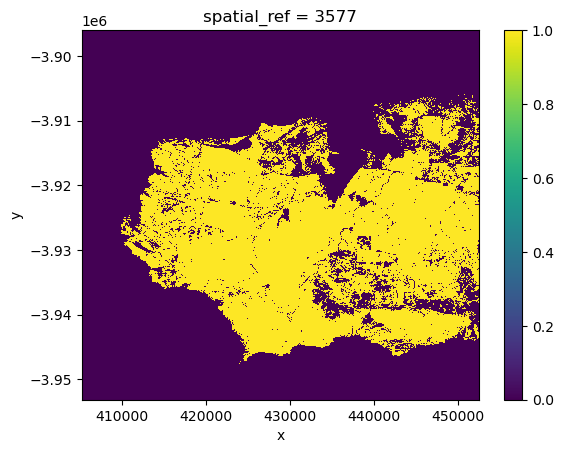

In [35]:
#plot the thresholded reduced delta bare soil index
threshold_dbsi.plot()

### Stacked agreement

In [90]:
# find where the tresholded data agrees, where 2 or more characterisitics indicate
# fire, we have agreement and cosider the area to be burnt
stacked_agreement = threshold_dbsi + threshold_dndvi + threshold_dnbr
stacked_thresholded = stacked_agreement >= 2 

## 6.Save the Data

### Dilate and erode data to remove small pixels

In [91]:
def dilrode_Delta_dataset(burn_dataset: xr.Dataset)-> xr.DataArray:
    dilated_data = xr.DataArray(morphology.binary_closing(burn_dataset, morphology.disk(3)).astype(burn_dataset.dtype),
                                 coords=burn_dataset.coords)
    erroded_data = xr.DataArray(morphology.erosion(dilated_data, morphology.disk(3)).astype(burn_dataset.dtype),
                                 coords=burn_dataset.coords)
    dilated_data = xr.DataArray(ndimage.binary_dilation(erroded_data, morphology.disk(3)).astype(burn_dataset.dtype),
                                 coords=burn_dataset.coords)
    return dilated_data

In [92]:
all_burn = dilrode_Delta_dataset(stacked_thresholded)
#all_burn.plot()

### Prepare to save the files

In [94]:
#build dynamic name
nm_sensor = "ls" #from dc.load 
nm_algo = "BAC"
nm_yeartype = "cy" #decision point here
nm_collection = "3"
nm_xy = xy #dynamic build from data loading process
nm_date = "2020" #see what is in bc, based upon nm_yeartype decision from above
nm_output = f'{nm_sensor}_{nm_algo}_{nm_yeartype}_{nm_collection}_{nm_xy}_{nm_date}_demo.tif'
nm_vect = f'{nm_sensor}_{nm_algo}_{nm_yeartype}_{nm_collection}_{nm_xy}_{nm_date}_demo.json'


### Generate vectors

In [95]:
#do some crs things that are required to save as vector
dataset_crs = all_burn.rio.crs
dataset_transform = all_burn.affine

In [96]:
# Use rasterio to create features
vector = rasterio.features.shapes(all_burn.data.astype('float32'),
                                mask=all_burn.data.astype('float32') == 1,
                                  transform = dataset_transform)
    
# rasterio.features.shapes outputs tuples. we only want the polygon coordinate portions of the tuples
vectored_data = list(vector)  # put tuple output in list

# Extract the polygon coordinates from the list
polygons = [polygon for polygon, value in vectored_data]

label='potential_burn'

# create a list with the data label type
labels = [label for _ in polygons]

# Convert polygon coordinates into polygon shapes
polygons = [shape(polygon) for polygon in polygons]

# Create a geopandas dataframe populated with the polygon shapes
data_gdf = gpd.GeoDataFrame(data={'attribute': labels},
                               geometry=polygons,
                               crs=wofs_summary.crs,)

#save output as GeoJSON
data_gdf.to_file(nm_vect, driver="GeoJSON")  
#data_gdf.to_file('allburn2_shp.shp') 

### Generate Rasters

In [97]:
all_burn.attrs["crs"] = wofs_summary.crs
all_burn = all_burn.astype('float64')

In [98]:
write_cog(geo_im=all_burn,
          fname=nm_output,
          overwrite=True,
          nodata=-999)

PosixPath('ls_BAC_cy_point6_3_x19y39_2020_demo.tif')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)